In [1]:
import pickle 
import numpy as np
import pandas as pd
import pathlib 
import os, sys
import torch 
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from torch.nn import functional as F
import scipy.linalg
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget

In [2]:
with open('/home/adam/ENR_Sven/moxie/data/processed/pedestal_profiles_ML_READY_ak_09022022.pickle', 'rb') as file:
    full_dict = pickle.load(file)
    train_X, train_y, train_mask, train_radii, train_ids = full_dict['train_dict']['padded']['profiles'],full_dict['train_dict']['padded']['controls'], full_dict['train_dict']['padded']['masks'], full_dict['train_dict']['padded']['radii'] , full_dict['train_dict']['padded']['pulse_time_ids'] 
    val_X, val_y, val_mask, val_radii, val_ids = full_dict['val_dict']['padded']['profiles'],full_dict['val_dict']['padded']['controls'], full_dict['val_dict']['padded']['masks'], full_dict['val_dict']['padded']['radii'], full_dict['val_dict']['padded']['pulse_time_ids']
    test_X, test_y, test_mask, test_radii, test_ids = full_dict['test_dict']['padded']['profiles'],full_dict['test_dict']['padded']['controls'], full_dict['test_dict']['padded']['masks'], full_dict['test_dict']['padded']['radii'], full_dict['test_dict']['padded']['pulse_time_ids']
    

In [3]:
# Helper Functions
def de_standardize(x, mu, var): 
    return (x*var) + mu

def standardize(x, mu, var): 
    return (x - mu) / var


In [5]:
from moxie.models.DIVA_ak_1 import DIVAMODEL
from moxie.data.profile_lightning_module import PLDATAMODULE_AK
from moxie.experiments.DIVA_EXP_AK import EXAMPLE_DIVA_EXP_AK

import pytorch_lightning as pl 
model_hyperparams = {'in_ch': 2, 'out_length':19,
    'mach_latent_dim': 7, 'stoch_latent_dim': 3,
    'beta_stoch': 10e-3,
    'beta_mach':  250., 'alpha_mach': 1.0, 'alpha_prof': 1.0,
    'loss_type': 'semi-supervised'}
model = DIVAMODEL(**model_hyperparams)
state_dict = torch.load('./samplemodelstatedict.pth')
model.load_state_dict(state_dict['model'])


<All keys matched successfully>

In [6]:
MP_norm, MP_var= state_dict['MP_norms']
D_norm, D_var= state_dict['D_norms']
T_norm, T_var= state_dict['T_norms']

train_mp_tensors = torch.tensor(train_y).float()
train_mp_normalized = standardize(train_mp_tensors, MP_norm, MP_var)

train_profiles = torch.tensor(train_X)

train_profiles_normalized = torch.clone(train_profiles).float()
train_profiles_normalized[:, 0] = standardize(train_profiles_normalized[:, 0], D_norm, D_var)
train_profiles_normalized[:, 1] = standardize(train_profiles_normalized[:, 1], T_norm, T_var)


In [10]:
batch_x, batch_y = train_mp_normalized[0:512], train_profiles_normalized[0:512]


In [85]:
sample_batch_mp = batch_x[10:11]

# Vary IP via interpolation between 1 and 10 MA 
interp_size = 100

mp_idx = -5 # Current is -5
mp_lims = (-0.5e6, -5e6)
mp_interp = standardize(torch.linspace(*mp_lims, interp_size), MP_norm[mp_idx], MP_var[mp_idx])

interp_sample_mp = torch.repeat_interleave(sample_batch_mp, interp_size, dim=0)
interp_sample_mp[:, mp_idx] = mp_interp

# Feed to the Prior Reg 
cond_prior_mu, cond_prior_var = model.p_zmachx(interp_sample_mp)

# The latent space from prior reg 
cond_z_mach, z_stoch = model.reparameterize(cond_prior_mu, cond_prior_var), torch.distributions.normal.Normal(0, 1).sample((interp_size, 3))
z_cond = torch.cat((z_stoch, cond_z_mach), 1)

# Predict the profiles and the machine parameters 
out_profs_cond, out_mp_cond = model.p_yhatz(z_cond), model.q_hatxzmach(cond_z_mach)

# Check the density limit in the out profs  (negative densities)
out_profs_cond_destand = torch.clone(out_profs_cond)
out_profs_cond_destand[:, 0] = de_standardize(out_profs_cond_destand[:, 0], D_norm, D_var)
out_profs_cond_destand[:, 1] = de_standardize(out_profs_cond_destand[:, 1], T_norm, T_var)
out_profs_cond_destand_clamped = torch.clamp(out_profs_cond_destand, min=None, max=0.0)
out_profs_cond_stand_clamped = torch.clone(out_profs_cond_destand_clamped)
out_profs_cond_stand_clamped[:, 0] = standardize(out_profs_cond_stand_clamped[:, 0], D_norm, D_var)
out_profs_cond_stand_clamped[:, 1] = standardize(out_profs_cond_stand_clamped[:, 1], D_norm, D_var)

out_profs_comparison = torch.zeros_like(out_profs_cond_destand)
out_profs_comparison[:, 0] = standardize(out_profs_comparison[:, 0], D_norm, D_var)
out_profs_comparison[:, 1] = standardize(out_profs_comparison[:, 1], D_norm, D_var)


compare_density_limit = F.mse_loss(out_profs_comparison, out_profs_cond_stand_clamped)

# Feed profiles to the encoder
mu_stoch, log_var_stoch, mu_mach, log_var_mach = model.q_zy(out_profs_cond)
encoded_z_stoch, encoded_z_mach = model.reparameterize(mu_stoch, log_var_stoch), model.reparameterize(mu_mach, log_var_mach)
z_encoded = torch.cat((encoded_z_stoch, encoded_z_mach), 1)

# Grab the predicted machine parameters
out_mp_encoded = model.q_hatxzmach(encoded_z_mach)

# Compare two out mps 
compare_mp_loss = F.mse_loss(out_mp_encoded, out_mp_cond)


In [84]:
print(compare_density_limit)

tensor(0.0073, grad_fn=<MseLossBackward0>)


In [60]:
d_profs, t_profs = out_profs_cond_destand[:, 0, :], out_profs_cond_destand[:, 1, :]

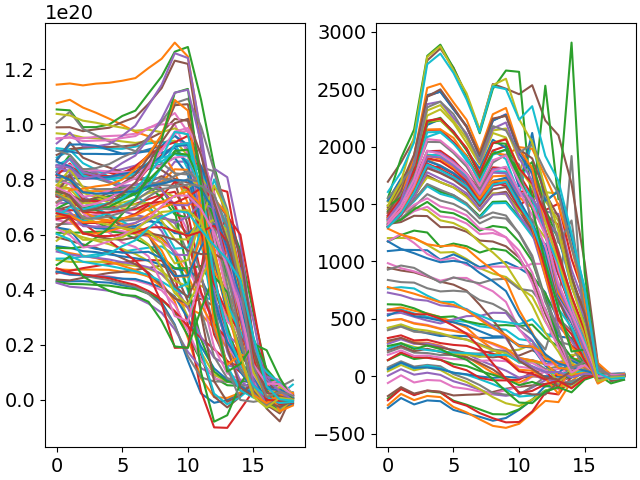

In [69]:
plt.close('all')
fig, axs = plt.subplots(1, 2, constrained_layout=True)
for d_prof, t_prof in zip(d_profs, t_profs):
    axs[0].plot(d_prof.detach())
    axs[1].plot(t_prof.detach())

In [ ]:
plt.close('all')
fig, axs = plt.subplots(1, 2, constrained_layout=True)
for d_prof, t_prof in zip(d_profs, t_profs):
    axs[0].plot(d_prof.detach())
    axs[1].plot(t_prof.detach())